# UAT for Cycle 02: Surrogate-First Exploration

This notebook demonstrates the User Acceptance Tests for the `SurrogateExplorer` module, showcasing its ability to intelligently filter and select structures.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from sklearn.decomposition import PCA

# Add project root to path
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from mlip_autopipec.config.models import ExplorerConfig, FingerprintConfig
from mlip_autopipec.modules.exploration import SurrogateExplorer

/app/.venv/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


## Setup: Download the Surrogate Model

In [2]:
import urllib.request

model_filename = "mace_mp_small.model"
model_url = f"https://github.com/stfc/janus-core/raw/main/tests/models/{model_filename}"

if not os.path.exists(model_filename):
    urllib.request.urlretrieve(model_url, model_filename)
else:
    pass

mace_mp_small.model already exists.


## UAT-C2-001: Filtering of Unphysical Structures

In [3]:
# 1. Create a plausible and an implausible structure
good_structure = bulk("Cu", "fcc", a=3.6, cubic=True)

bad_structure = good_structure.copy()
positions = bad_structure.get_positions()
positions[1] = positions[0] + np.array([0.1, 0.1, 0.1])  # Move two atoms very close
bad_structure.set_positions(positions)


Structures created. Plausible: 1, Implausible: 1.


In [4]:
# 2. Configure and run the pre-screening
fingerprint_config_cu = FingerprintConfig(species=["Cu"])
explorer_config_cu = ExplorerConfig(
    surrogate_model_path=model_filename, max_force_threshold=10.0, fingerprint=fingerprint_config_cu
)

explorer = SurrogateExplorer(explorer_config_cu)
structures_to_screen = [good_structure, bad_structure]

screened_structures = explorer._pre_screen_structures(structures_to_screen)


assert len(screened_structures) == 1

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/app/.venv/lib/python3.12/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Input structures: 2
Output structures after screening: 1
✓ UAT-C2-001 Passed: The unphysical structure was correctly filtered out.


## UAT-C2-002: Intelligent Selection of Diverse Structures (FPS)

In [5]:
# 1. Create a redundant dataset with outliers
base_si = bulk("Si", "diamond", a=5.43)
structures = [base_si]

# Add redundant structures (small rattles)
for _ in range(100):
    rattled = base_si.copy()
    rattled.rattle(stdev=0.05)
    structures.append(rattled)

# Add outlier structures (large deformations)
for strain in np.linspace(0.9, 1.1, 5):
    strained = base_si.copy()
    strained.set_cell(strained.cell * strain, scale_atoms=True)
    structures.append(strained)


Total generated structures: 106


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/app/.venv/lib/python3.12/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


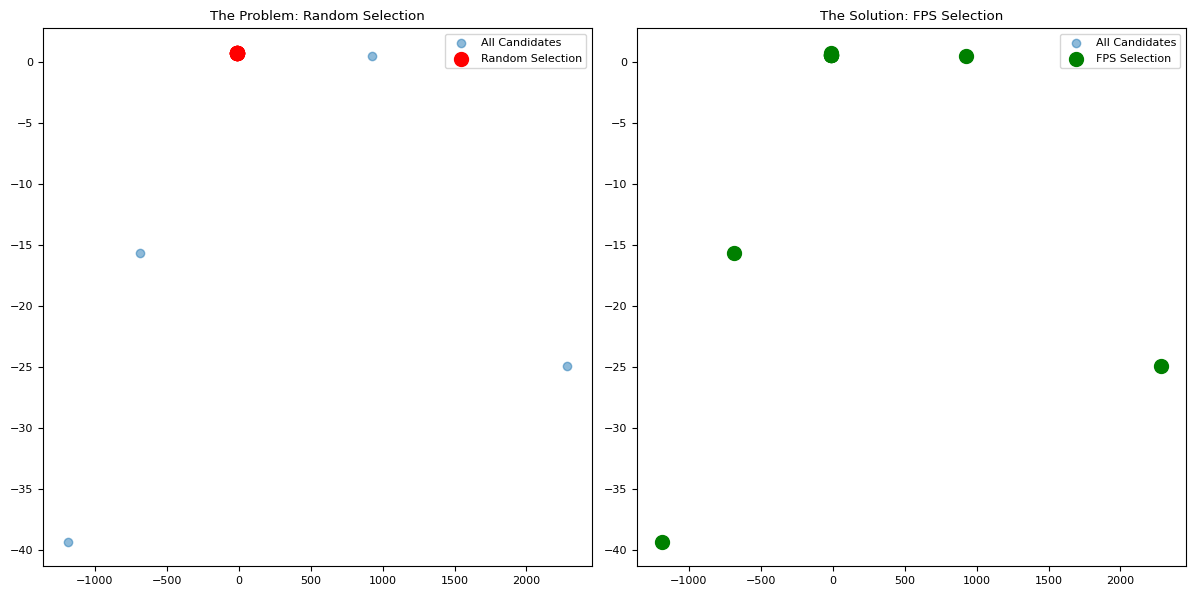

✓ UAT-C2-002 Visualized: Note how FPS spreads its selections to cover the space, unlike the random sample.


In [6]:
# 2. Configure explorer for Si and calculate all fingerprints
fingerprint_config_si = FingerprintConfig(species=["Si"])
explorer_config_si = ExplorerConfig(
    surrogate_model_path="mace_mp_small.model",
    max_force_threshold=20.0,  # Higher threshold to avoid filtering strained structures
    fingerprint=fingerprint_config_si,
)
explorer_si = SurrogateExplorer(explorer_config_si)
fingerprints = explorer_si._calculate_fingerprints(structures)

# 3. Run FPS to select 10 structures
selected_indices = explorer_si._farthest_point_sampling(fingerprints, 10)
random_indices = np.random.choice(len(structures), 10, replace=False)

# 4. Visualize the results with PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(fingerprints)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(points_2d[:, 0], points_2d[:, 1], alpha=0.5, label="All Candidates")
plt.scatter(
    points_2d[random_indices, 0],
    points_2d[random_indices, 1],
    c="red",
    s=100,
    label="Random Selection",
)
plt.title("The Problem: Random Selection")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(points_2d[:, 0], points_2d[:, 1], alpha=0.5, label="All Candidates")
plt.scatter(
    points_2d[selected_indices, 0],
    points_2d[selected_indices, 1],
    c="green",
    s=100,
    label="FPS Selection",
)
plt.title("The Solution: FPS Selection")
plt.legend()
plt.tight_layout()
plt.show()
